In [95]:
import numpy as np
import pandas as pd
from pygimli.meshtools import readGmsh
import pygimli as pg
import glob

from scipy.spatial import distance_matrix
from scipy.interpolate import griddata
from itertools import combinations
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

from scipy.spatial import Delaunay, cKDTree
from pygimli.physics import ert
from ertoolbox import inversion
from ertoolbox import ert_postprocessing
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
from shapely.geometry import Polygon, LineString

In [96]:
folder = 'p:/11209233-mad09a2023ijsselmeer3d/C_Work/02_FM/03_postprocessing/09_input_tomografische_metingen/voorhaven_kwz/sal_tem'

counter = 0

for csv in glob.glob(f"{folder}/*.csv"):
    counter+=1
    if counter == 25:
        data = pd.read_csv(csv)



In [97]:
data.columns =['x', 'z', 'salinity', 'temperature']

In [98]:
pressure = 1025*9.81*-data['z']/10000

data["resistivity"] = 1 / ert_postprocessing.salinity_to_conductivity(
        data["salinity"], data["temperature"], pressure
    )

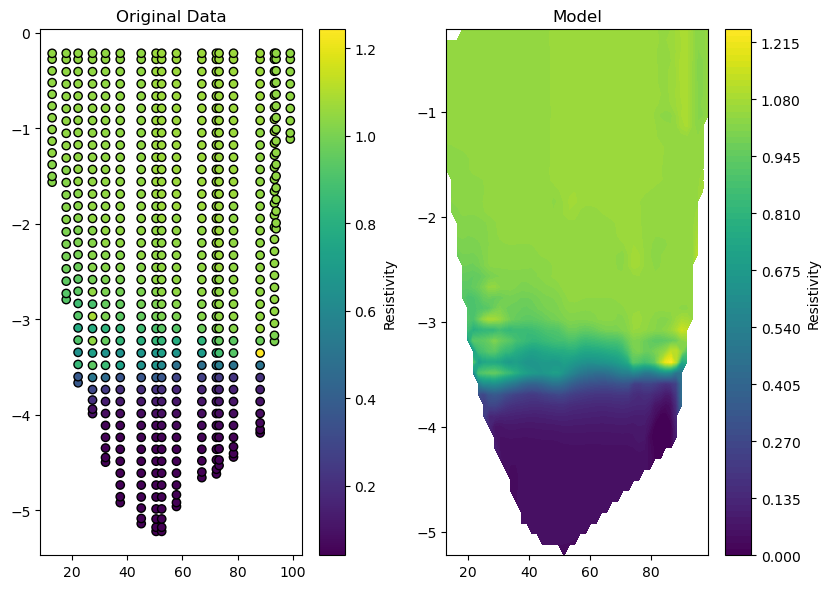

In [99]:
x_min, x_max = data['x'].min(), data['x'].max()
z_min, z_max = data['z'].min(), data['z'].max()
grid_size = 50  #

# Create a regular grid
x_grid = np.linspace(x_min, x_max, grid_size)
z_grid = np.linspace(z_min, z_max, grid_size)
X_grid, Z_grid = np.meshgrid(x_grid, z_grid)

# Stack grid data
xyz = np.column_stack([X_grid.flatten(),Z_grid.flatten()])

# Prepare data for interpolation
points = data[['x', 'z']].values 
values = data['resistivity'].values
temp = data['temperature'].values
# Interpolate
grid_values = griddata(points, values, (X_grid, Z_grid), method='cubic')
grid_values[grid_values<0] = 0.001
grid_values_og = grid_values.copy()
grid_temp = griddata(points, values, (X_grid, Z_grid), method='cubic')

# Plot original points
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(data['x'], data['z'], c=data['resistivity'], cmap='viridis', edgecolor='k')
plt.title('Original Data')
plt.colorbar(label='Resistivity')

# Plot interpolated grid
plt.subplot(1, 3, 2)
plt.contourf(X_grid, Z_grid, grid_values, levels=100, cmap='viridis')
plt.title('Model')
plt.colorbar(label='Resistivity')
plt.tight_layout()


In [100]:
def euclidean_distance(p1, p2):
    """Calculate the Euclidean distance between two points p1 and p2."""
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def find_closest_tuple(tuples_list, target):
    """Find the closest tuple in the list to the target tuple."""
    closest_tuple = min(tuples_list, key=lambda x: euclidean_distance(x, target))
    return closest_tuple

def polygon_outline(X_grid, Z_grid, grid_values):
    nan_contour = plt.contour(X_grid, Z_grid, np.isnan(grid_values), levels=[0.5], colors='red')

    contour_points = []
    for collection in nan_contour.collections:
        for path in collection.get_paths():
            contour_points.append([(point[0], point[1]) for point in path.vertices])

    contour_line = contour_points[0]
    contour_line = [point for point in contour_line if point[1] <= -1]

    if contour_line[0] != contour_line[-1]:
        contour_line.append(contour_line[0])  

    poly = pg.meshtools.createPolygon(contour_line, isClosed=True, marker=0)
    return contour_line, poly


def polygon_levels(level, mark, X_grid, Z_grid, grid_values, contour_line):
    contour_split = plt.contour(X_grid, Z_grid, grid_values, levels=[level], colors='blue')
    contour_points_split = []
    for collection in contour_split.collections:
        for path in collection.get_paths():
            contour_points_split.append([(point[0], point[1]) for point in path.vertices])

    contour_line_split = contour_points_split[0]

    max_tuple = max(contour_line_split, key=lambda x: x[0])
    min_tuple = min(contour_line_split, key=lambda x: x[0])

    closestmax = find_closest_tuple(contour_line, max_tuple)
    closestmin = find_closest_tuple(contour_line, min_tuple)

    a = [t for t in contour_line if t[0] > closestmin[0]]
    a2 = [t for t in a if t[0] < closestmax[0]]
    a3 = [t for t in a2 if t[1] < closestmin[1]]

    a4 = [t for t in a2 if t[1] < closestmax[1]]
    a4.sort(key=lambda x: x[0], reverse=True)

    contour_line_split = contour_line_split +  a4

    salt = pg.meshtools.createPolygon(contour_line_split, isClosed=True, marker=mark)
    return salt

C:\Users\leentvaa\AppData\Local\Temp\ipykernel_24452\2051880547.py:11: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in nan_contour.collections:
C:\Users\leentvaa\AppData\Local\Temp\ipykernel_24452\4089610303.py:31: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in contour_split.collections:


(<Axes: xlabel='$x$ in m', ylabel='$y$ in m'>,
 <matplotlib.colorbar.Colorbar at 0x267080fca90>)

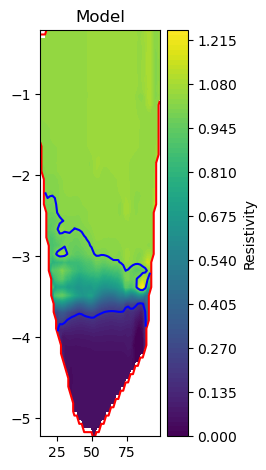

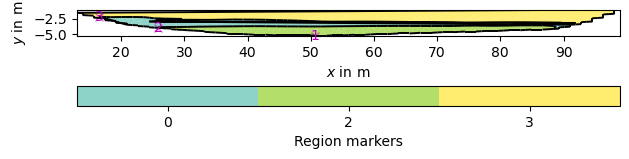

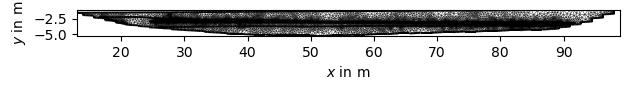

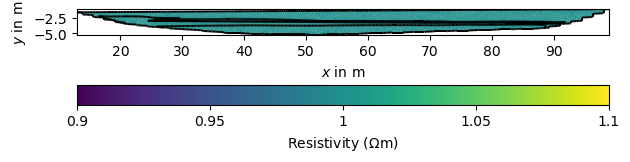

In [101]:
plt.subplot(1, 3, 2)
plt.contourf(X_grid, Z_grid, grid_values, levels=100, cmap='viridis')
plt.title('Model')
plt.colorbar(label='Resistivity')
plt.tight_layout()
levels = [0.2]

nan_contour = plt.contour(X_grid, Z_grid, np.isnan(grid_values), levels=[0.5], colors='red')

contour_points = []
for collection in nan_contour.collections:
    for path in collection.get_paths():
        contour_points.append([(point[0], point[1]) for point in path.vertices])

contour_line = contour_points[0]
contour_line = [point for point in contour_line if point[1] <= -1]

if contour_line[0] != contour_line[-1]:
    contour_line.append(contour_line[0])  # Close the polygon


poly = pg.meshtools.createPolygon(contour_line, isClosed=True, marker=1)

salt = polygon_levels(0.2, 2, X_grid, Z_grid, grid_values, contour_line)
salt2 = polygon_levels(1, 3, X_grid, Z_grid, grid_values, contour_line) 

geom = poly + salt + salt2
geominv = poly
pg.show(geom)

mesho = mt.createMesh(geom, quality=34)
meshinv = mt.createMesh(geominv, quality=34)
pg.show(mesho, label=pg.unit('res'), showMesh=True)

# rhomap = [[0, 0.8],
#         [2, 0.2],
#         [3, 1],
#      ]
rhomap = [[0, 1],
        [2, 1],
        [3, 1],
     ]
pg.show(mesho, data=rhomap, label=pg.unit('res'), showMesh=False)




13/12/24 - 15:03:59 - pyGIMLi - INFO - Data error estimate (min:max)  0.010016445486909829 : 0.48572671766211634


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


13/12/24 - 15:04:00 - pyGIMLi - INFO - Found 1 regions.
13/12/24 - 15:04:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
13/12/24 - 15:04:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
13/12/24 - 15:04:00 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2360 Cells: 4092 Boundaries: 3382
13/12/24 - 15:04:00 - pyGIMLi - INFO - Use median(data values)=2.1147702490415123
13/12/24 - 15:04:00 - pyGIMLi - INFO - Created startmodel from forward operator: 1023, min/max=2.114770/2.114770
13/12/24 - 15:04:00 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000267080BC590>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000267098DA840>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000266F77129D0>
min/max (data): 0.45/3.8
min/max (error): 1%/48.57%
min/max (start model): 2.11/2.11
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 2071.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   36.61 (dPhi = 98.16%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   21.71 (dPhi = 39.67%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   20.29 (dPhi = 6.20%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =   19.73 (dPhi = 2.34%) lam: 20.0
---------------

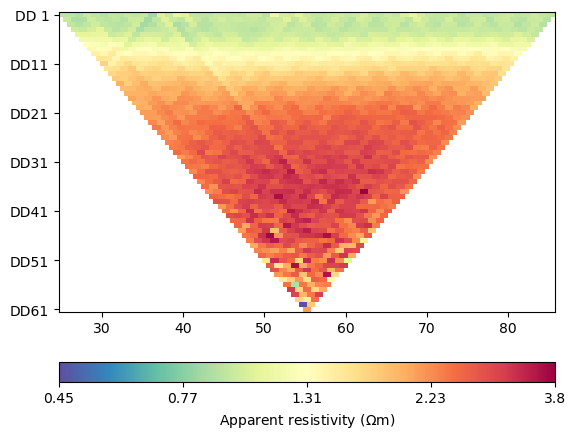

In [102]:
# Create a DataFrame
df = pd.DataFrame(
    {"x": X_grid.flatten(), "z": Z_grid.flatten(), "value": grid_values.flatten()}
) 
from scipy import interpolate

# Only use valid data points
df = df.dropna()
# #take 1 node above the bottom
min_z_indices = df.groupby('x')['z'].idxmin()
df = df.drop(min_z_indices)
df.reset_index(drop=True, inplace=True)

min_z_indices = df.groupby("x")["z"].idxmin()
min_z_df = df.loc[min_z_indices]
min_z_df.reset_index(drop=True, inplace=True)

x_points = min_z_df['x']
z_points = min_z_df['z']
# Interpolation
distance = 1  # cm

# Calculate the distances between the original points
distances = np.sqrt(np.diff(x_points)**2 + np.diff(z_points)**2)

# Calculate cumulative distances
cumulative_distances = np.concatenate(([0], np.cumsum(distances)))

# New distance points from the start to the end
new_distances = np.arange(0, cumulative_distances[-1], distance)

# Interpolating
new_x = np.interp(new_distances, cumulative_distances, x_points)
new_z = np.interp(new_distances, cumulative_distances, z_points)

new_x = np.append(new_x, new_x[-1])
new_x = np.append(new_x[0], new_x)
new_z = np.append(new_z, 0)
new_z = np.append(0, new_z)

# Resulting interpolated points
interpolated_points = np.column_stack((new_x, new_z))
interpolated_points_mesh = np.vstack([interpolated_points[0],interpolated_points, interpolated_points[0]])
interpolated_points_mesh[0][1] = 0
interpolated_points_mesh[-1][1] = 0

def calculate_distances(points):
    """
    Calculate distances between consecutive points.

    Parameters:
    points (array-like): A 2D array or list of points where each point is represented as [x, y].

    Returns:
    np.ndarray: An array of distances between consecutive points.
    """
    points = np.array(points)  # Ensure the input is a NumPy array
    # Calculate the distances between consecutive points
    distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
    return distances


distances = calculate_distances(interpolated_points)

# Define electrode positions
EZ = new_z
EX = new_x

start_index_EX = len(EX) // 2 - 32  # 32 elements before the middle
end_index_EX = len(EX) // 2 + 32    # 32 elements after the middle
middle_64_EX = EX[start_index_EX:end_index_EX]
start_index_EZ = len(EZ) // 2 - 32  # 32 elements before the middle
end_index_EZ = len(EZ) // 2 + 32    # 32 elements after the middle
middle_64_EZ = EZ[start_index_EZ:end_index_EZ]
electrodes = [[x, y] for x, y in zip(middle_64_EX, middle_64_EZ)]

# Create measurement scheme
# schemes = ['wa', 'wb', 'pp', 'pd', 'dd', 'slm', 'hw', 'gr']
scheme = ert.createData(elecs=electrodes, schemeName='dd')

# Make simulation data
simdata = ert.simulate(
         mesh=mesho, scheme=scheme, res = rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337
    )

ert.show(simdata)
mrg = ert.ERTManager(simdata, verbose=True)
inversion_dd_1 = mrg.invert(mesh = meshinv)
# mgr.showResultAndFit()

ValueError: Contour levels must be increasing

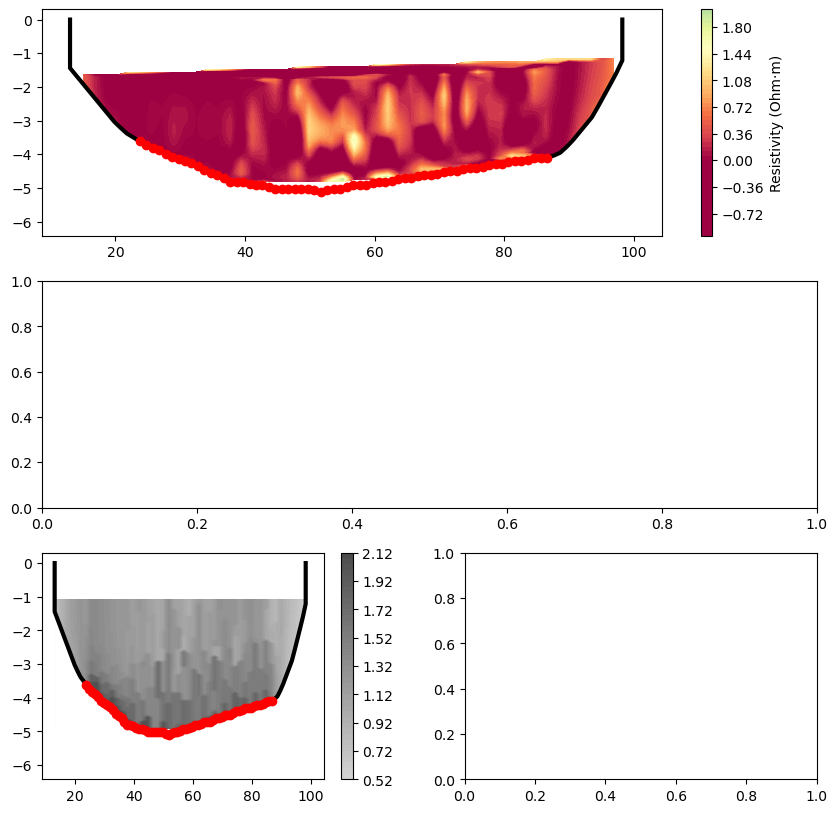

In [103]:
# # mgr.showResultAndFit()
# Extract coordinates (x, z) of cell centers and resistivity values
electrodes = np.array(electrodes)
mesh = mrg.paraDomain
coverage_values = mrg.coverage()
cell_centers = np.array([cell.center() for cell in mesh.cells()])
x, z = cell_centers[:, 0], cell_centers[:, 1]

# Define grid parameters
x_min, x_max = x.min(), x.max()
z_min, z_max = z.min(), z.max()
grid_size = 50  # Number of grid points along each axis
x_grid = np.linspace(x_min, x_max, grid_size)
z_grid = np.linspace(z_min, z_max, grid_size)
X_grid, Z_grid = np.meshgrid(x_grid, z_grid)
Y_grid = np.zeros(np.shape(X_grid))
xyz = np.column_stack([X_grid.flatten(),Z_grid.flatten()])
points = cell_centers[:,0:2]
values = inversion_dd_1

# # Interpolate
maxclim = 3
coverage_grid = griddata(points, coverage_values, (X_grid, Z_grid), method='nearest')
grid_values = griddata(points, values, (X_grid, Z_grid), method='cubic')
grid_values[grid_values >= maxclim] = maxclim
grid_values[grid_values < 0] = 0

#PLOT

# Create a figure
fig = plt.figure(figsize=(10, 10))  # Adjust size as needed

# Define grid layout
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])  # 3 rows, 2 columns

# Add subplots
ax1 = fig.add_subplot(gs[0, :])  # First row (spans both columns)
ax2 = fig.add_subplot(gs[1, :])  # Second row (spans both columns)
ax3 = fig.add_subplot(gs[2, 0])  # Third row, first column
ax4 = fig.add_subplot(gs[2, 1])  # Third row, second column

# Plot contour
# plt.figure(figsize=(20, 5))
contour = ax1.contourf(X_grid, Z_grid, grid_values-1, cmap='Spectral',levels=50, vmin=0, vmax=maxclim) #place levels for smoother colorbar
ax1.fill_between(np.append(new_x,100), np.append(new_z,0), y2=min(new_z) - 1, color='white', zorder=3)

ax1.plot(new_x,new_z,color='black', linewidth=3, zorder = 4)
ax1.scatter(electrodes[:,0], electrodes[:,1],color='red', zorder = 5)
fig.colorbar(contour, ax=ax1, label="Resistivity (Ohm·m)")

# # Plot original model
# # Define grid parameters
# x_min, x_max = data['x'].min(), data['x'].max()
# z_min, z_max = data['z'].min(), data['z'].max()

# # Create a regular grid
# x_grid = np.linspace(x_min, x_max, grid_size)
# z_grid = np.linspace(z_min, z_max, grid_size)
# X_grid, Z_grid = np.meshgrid(x_grid, z_grid)
# Y_grid = np.zeros(np.shape(X_grid))

# # Plot original points

# ogmodel = ax2.contourf(X_grid, Z_grid, grid_values_og, levels=100, cmap='Spectral',vmin=0, vmax=maxclim)
# ax2.scatter(data['x'], data['z'], c=data['resistivity'], cmap='Spectral', edgecolor='k',vmin=0, vmax=maxclim)
# ax2.set_title('Original Data')
# fig.colorbar(ogmodel, ax=ax2, label="Resistivity (Ohm·m)")

#plot coverage
# plt.figure(figsize=(20, 5))
ax3.fill_between(np.append(new_x,100), np.append(new_z,0), y2=min(new_z) - 1, color='white', zorder=3)
coverage = ax3.contourf(X_grid, Z_grid, coverage_grid, cmap='binary', levels=50, vmin=0, vmax=maxclim) #place levels for smoother colorbar
ax3.plot(new_x,new_z,color='black', linewidth=3, zorder = 4)
ax3.scatter(electrodes[:,0], electrodes[:,1],color='red', zorder = 5)
fig.colorbar(coverage, ax=ax3)
# plt.colorbar(coverage, label="Coverage")

# Plot contour with coverage
# plt.figure(figsize=(20, 5))
coverage = ax4.contourf(X_grid, Z_grid, coverage_grid ,levels=[min(coverage_values), 0.2], colors='white', zorder=3) 
ax4.fill_between(np.append(new_x,100), np.append(new_z,0), y2=min(new_z) - 1, color='white', zorder=3)
contour2 = ax4.contourf(X_grid, Z_grid, grid_values, cmap='Spectral',levels=50, vmin=0, vmax=maxclim) #place levels for smoother colorbar
ax4.plot(new_x,new_z,color='black', linewidth=3, zorder = 4)
ax4.scatter(electrodes[:,0], electrodes[:,1],color='red', zorder = 5)
fig.colorbar(contour2, ax=ax4)

x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])


fig.tight_layout()
